# PPO-CLIP

PPO-CLIP objective is
$$
\arg \max_\theta\mathbb{E}_{a,s\sim \pi_{old}}[\frac {\pi_\theta(a|s)}{\pi_{old}(a|s)} * \hat{A}]=\arg \max_\theta\mathbb{E}_{a,s\sim \pi_{old}}[r_\theta(a|s) * \hat{A}]
$$

We want to reduce variance of policy gradient as large gradients might cause diversion of the policy.
This can be done by clipping the gradient. Let's make sure that it always falls within a small range:

$$
(1-\epsilon)*\hat{A} \leq r_\theta*\hat{A} \leq (1+\epsilon)*\hat{A}
$$

To support both positive and negative advantage values, we can rewrite the above condition into the following differentiable function:

$$
\mathcal{L}^{CLIP}=\mathbb{E}_{\pi_{old}}[min(r_\theta*\hat{A}, clip(r_\theta, 1-\epsilon, 1+\epsilon)*\hat{A})]
$$

Advantage can be calculated by either MC or TD(0) estimates. With TD(0) we'll need a value function estimate.
$$
\hat{A} = R_{t+1} + \gamma*v(s_{t+1}) - v(s_t)
$$

Value update is constructed from a sample of Bellman's expectation equation. We use MSE loss to push value estimate towards TD(0) bootstrapped targets.

$$
\mathcal{L}^V= ([[R_{t+1} + v(s_t+1)]] - v(s_t))^2
$$

Additional term is an entropy bonus $S$, which promotes more uniform distributions:

$$
S = \mathbb{E}[-H(\pi_\theta(s))]
$$

Final loss term takes the form:
$$
\mathcal{L}^{CLIP+V+S}=\mathcal{L}^{CLIP}+c_1*\mathcal{L}^{V}+c_2*S
$$

## Links
* [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

In [1]:
import gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## Models

In [2]:
class DiscretePolicyModel(torch.nn.Module):
    def __init__(self, state_size, actions_size, hidden_size):
        super().__init__()
        self.policy_nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, actions_size),
        )

    def forward(self, state):
        return torch.distributions.Categorical(logits=self.policy_nn(state))

    def act(self, state):
        with torch.no_grad():
            dist = self.forward(state)
            action = dist.sample()
            return action, dist.log_prob(action).sum(axis=-1)

    def action_log_prob(self, state, action):
        dist = self.forward(state)
        return dist.log_prob(action).sum(axis=-1)


dpm = DiscretePolicyModel(2, 2, 64)
dpm, dpm.act(torch.tensor([1, 2.])), dpm.action_log_prob(torch.tensor([1, 2.]), torch.tensor(1))

(DiscretePolicyModel(
   (policy_nn): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): Tanh()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): Tanh()
     (4): Linear(in_features=64, out_features=2, bias=True)
   )
 ),
 (tensor(0), tensor(-0.4628)),
 tensor(-0.9929, grad_fn=<SumBackward1>))

In [3]:
class ContinuousPolicyModel(torch.nn.Module):
    def __init__(self, state_size, actions_size, hidden_size, action_scaling):
        super().__init__()
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, actions_size),
        )

        self.action_scaling = action_scaling
        self.log_std = torch.nn.Parameter(-0.5 * torch.ones(actions_size, dtype=torch.float32))

    def forward(self, state):
        mus = self.mu(state)
        dist = torch.distributions.Normal(mus * self.action_scaling, torch.exp(self.log_std))
        return dist

    def act(self, state):
        with torch.no_grad():
            dist = self.forward(state)
            action = dist.sample()
            return action, dist.log_prob(action).sum(axis=-1)

    def action_log_prob(self, state, action):
        dist = self.forward(state)
        return dist.log_prob(action).sum(axis=-1)


cpm = ContinuousPolicyModel(2, 1, 64, 1)
cpm, cpm.forward(
    torch.tensor([1., 2])
), \
cpm.act(torch.tensor([1, 2.])), \
cpm.action_log_prob(torch.tensor([1, 2.]),
                    torch.tensor([0.5]))

(ContinuousPolicyModel(
   (mu): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): Tanh()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): Tanh()
     (4): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 Normal(loc: tensor([0.2900], grad_fn=<MulBackward0>), scale: tensor([0.6065], grad_fn=<ExpBackward0>)),
 (tensor([0.8697]), tensor(-0.8757)),
 tensor(-0.4789, grad_fn=<SumBackward1>))

In [4]:
class ValueModel(torch.nn.Module):
    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.value_nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        return torch.squeeze(self.value_nn(state), -1)


vm = ValueModel(2, 64)
vm, vm(torch.tensor([1, 2.]))

(ValueModel(
   (value_nn): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): Tanh()
     (2): Linear(in_features=64, out_features=64, bias=True)
     (3): Tanh()
     (4): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 tensor(0.1913, grad_fn=<SqueezeBackward1>))

## Training

In [12]:
def test_policy(policy_model, env_name='CartPole-v1', episodes=1, render=True):
    with gym.make(env_name) as env:
        total_rewards = []
        for e in range(episodes):
            total_reward = 0
            state = env.reset()
            done = False
            while not done:
                if render:
                    env.render()
                state, reward, done, _ = env.step(policy_model.act(torch.as_tensor(state))[0].numpy())
                total_reward += reward
            total_rewards.append(total_reward)
        return np.mean(total_rewards)


def train_ppo(env_name,
              episodes=3000,
              gamma=0.98,
              eps=0.1,
              entropy_loss_weight=0.01,
              hidden_size=256,
              early_stopping_reward=300,
              train_every_step=50,
              normalize_advantage=True,
              lr=0.001,
              max_steps=1000,
              gradient_iters=20,
              max_policy_kl=0.02):
    with gym.make(env_name) as env:
        if type(env.action_space) is gym.spaces.Discrete:
            policy_model = DiscretePolicyModel(env.observation_space.shape[0], env.action_space.n, hidden_size)
        else:
            policy_model = ContinuousPolicyModel(env.observation_space.shape[0], env.action_space.shape[0], hidden_size,
                                                 env.action_space.high[0])
        value_model = ValueModel(env.observation_space.shape[0], hidden_size)
        policy_model.train()
        value_model.train()
        optim1 = torch.optim.Adam(policy_model.parameters(), lr=lr)
        optim2 = torch.optim.Adam(value_model.parameters(), lr=lr)

        progress = tqdm(range(episodes))
        episode_lengths = []
        losses = []
        total_rewards = []
        rewards = []
        values = []
        policy_entropies = []
        for _ in progress:
            state = torch.as_tensor(env.reset())
            trace = []
            total_reward = 0
            for step in range(max_steps):
                action, action_logprob = policy_model.act(state)
                with torch.no_grad():
                    value = value_model(state)
                new_state, test_reward, done, _ = env.step(action.numpy())
                total_reward += test_reward

                trace.append({
                    'state': state,
                    'value': value,
                    'action_logprob': action_logprob,
                    'action': action,
                    'reward': test_reward,
                    'new_state': torch.as_tensor(new_state),
                    'done': done
                })
                state = torch.as_tensor(new_state)

                if done or (step % train_every_step == 0 and step > 1):
                    # ***************** TRAINING STEP ****************
                    new_state_value = 0
                    if not done:
                        with torch.no_grad():
                            new_state_value = value_model.forward(trace[-1]['new_state'])

                    # Calculate n-step returns
                    returns = []
                    r = new_state_value
                    for t in trace[::-1]:
                        r = r * gamma + t['reward']
                        returns.append(r)
                    returns = returns[::-1]

                    advantages = []
                    for r, t in zip(returns, trace):
                        t['advantage'] = (r - t['value']).item()
                        advantages.append(t['advantage'])

                    if normalize_advantage:
                        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

                    # ************** PPO-CLIP policy gradient update ***************
                    for iter in range(gradient_iters):
                        clip_losses = []
                        new_log_probs = []
                        old_log_probs = []
                        for advantage, t in zip(advantages, trace):
                            action_log_prob = policy_model.action_log_prob(t['state'], t['action'])
                            old_action_log_prob = t['action_logprob']
                            new_log_probs.append(action_log_prob)
                            old_log_probs.append(old_action_log_prob)
                            ratio = torch.exp(action_log_prob - old_action_log_prob)
                            clip_losses.append(
                                torch.min(ratio * advantage, torch.clamp(ratio, 1 - eps, 1 + eps) * advantage)
                            )
                        # negative expected returns for gradient **ascent**
                        clip_losses = -torch.stack(clip_losses).mean()

                        entropy = -torch.stack(new_log_probs).mean()
                        kl = -(torch.stack(new_log_probs) - torch.as_tensor(old_log_probs)).mean().item()

                        if iter > 0 and kl > max_policy_kl:
                            # print(f"{iter}: training early stopping due to high KL == {kl}")
                            break

                        # Policy update
                        policy_loss = clip_losses - entropy_loss_weight * entropy
                        optim1.zero_grad()
                        policy_loss.backward()
                        optim1.step()

                    # ********************* Value loss & update *************************
                    for _ in range(gradient_iters):
                        value_losses = []
                        for r, t in zip(returns, trace):
                            value = value_model.forward(t['state'])
                            value_loss = (r - value) ** 2
                            value_losses.append(value_loss)
                        value_losses = torch.stack(value_losses).mean()

                        # Value update
                        optim2.zero_grad()
                        value_losses.backward()
                        optim2.step()

                    losses.append(policy_loss.item())
                    values.append(np.mean([t['value'].item() for t in trace]))
                    rewards.append(np.mean([t['reward'] for t in trace]))
                    policy_entropies.append(entropy.item())

                    progress.set_description(
                        f'Episode lengths:{np.mean(episode_lengths[-10:]):04.0f}; total rewards:{np.mean(total_rewards[-10:]):04.0f}; '
                        f'value estimates:{np.mean(values[-10:]):05.1f}; entropy:{np.mean(policy_entropies[-10:]):.04f}')
                    trace = []

                if done:
                    test_reward = test_policy(policy_model, env_name=env_name, episodes=1, render=False)
                    episode_lengths.append(step)
                    total_rewards.append(test_reward)
                    break

            if len(total_rewards) >= 10 and np.mean(total_rewards[-10:]) > early_stopping_reward:
                print(f'Early stopping, total rewards > {early_stopping_reward}')
                break

        fig, axs = plt.subplots(5, 1, figsize=(10, 15))
        axs[0].plot(episode_lengths)
        axs[0].set_title('Episode lengths')
        axs[1].plot(total_rewards)
        axs[1].set_title('Total reward')
        axs[2].plot(losses)
        axs[2].set_title('Loss')
        axs[3].plot(values)
        axs[3].set_title('Value estimates')
        axs[4].plot(policy_entropies)
        axs[4].set_title('Policy entropy')

        return policy_model

## CartPole

  0%|          | 0/3000 [00:00<?, ?it/s]

/home/vslaykovsky/anaconda3/envs/python3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vslaykovsky/anaconda3/envs/python3.7/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Early stopping, total rewards > 300


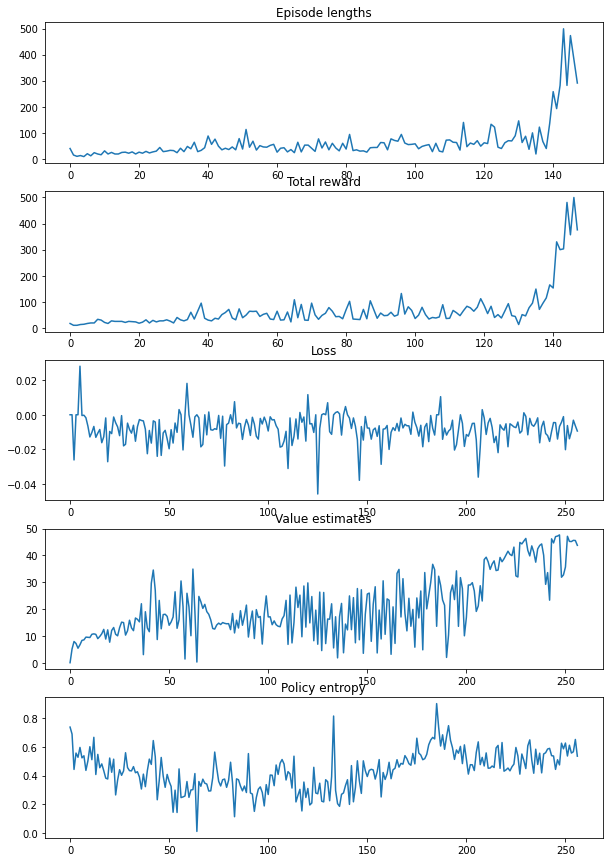

In [13]:
policy_model = train_ppo('CartPole-v1', entropy_loss_weight=0., gamma=0.98, eps=0.1, episodes=3000,
                         early_stopping_reward=300, train_every_step=50, gradient_iters=10, max_policy_kl=0.02,
                         lr=0.001)

In [14]:
test_policy(policy_model, 'CartPole-v1', episodes=2)

326.5

## Pendulum-v1

  0%|          | 0/100 [00:00<?, ?it/s]

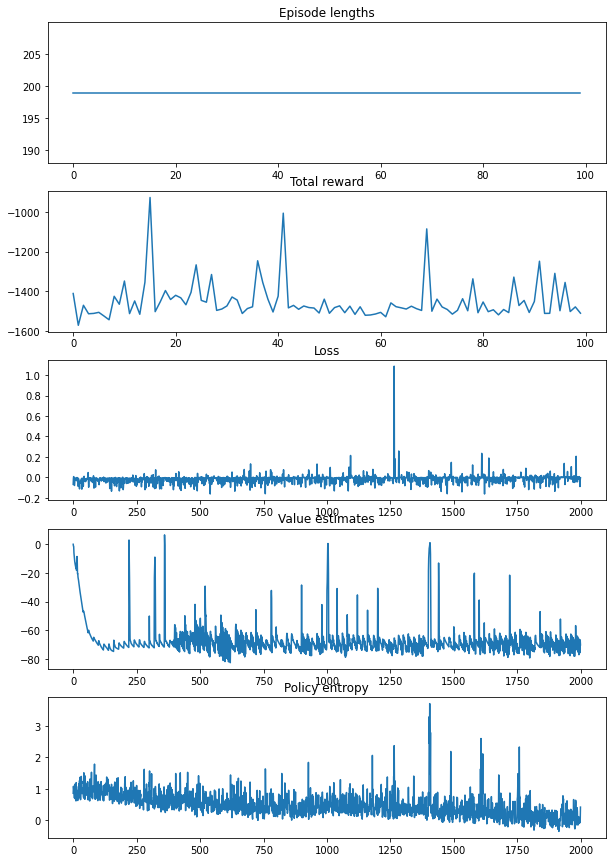

In [15]:
policy_model = train_ppo('Pendulum-v1', entropy_loss_weight=0.01, gamma=0.9, eps=0.2, episodes=25,
                         early_stopping_reward=-200, train_every_step=10, hidden_size=64,
                         gradient_iters=20, max_policy_kl=0.02, lr=0.001, normalize_advantage=True)

In [16]:
test_policy(policy_model, 'Pendulum-v1', episodes=2, render=True)

-1457.6331702090151